In [1]:
# !pip install -q transformers datasets

In [2]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("hugging_face")
secret_value_1 = user_secrets.get_secret("wandb")

In [3]:
import wandb
wandb.login(key=secret_value_1)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
#Load necessary libraries
from datasets import load_dataset
from PIL import Image
import itertools
from transformers import ViltProcessor, ViltForQuestionAnswering, TrainingArguments, Trainer, DefaultDataCollator

2024-02-25 15:20:14.151553: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-25 15:20:14.151663: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-25 15:20:14.264336: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# from huggingface_hub import notebook_login
# notebook_login()

In [6]:
# ! export HF_TOKEN={secret_value_0}

In [7]:
model_checkpoint = "dandelin/vilt-b32-mlm"

In [8]:
#model_checkpoint = "dandelin/vilt-b32-finetuned-vqa"

In [9]:
import pandas as pd

# Replace 'your_file.csv' with the actual name of your CSV file
csv_file_path = '/kaggle/input/comecsv/Come.csv'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_path)

In [10]:
import pandas as pd

# Assuming you have a DataFrame named 'df' loaded from your CSV file
# Replace 'your_file.csv' with the actual file path if needed

# Shuffle the DataFrame randomly
#df = df.sample(frac=1, random_state=42)  # Set a random_state for reproducibility

In [11]:
df

,image_id,question_id,question,question_type,multiple_choice_answer,answer_type
0,IMG00156,45,what is this?,what is,auniati_satra,other
1,IMG00202,51,what is the best timing to visit this place?,what is,anytime,other
2,IMG00188,45,what is this?,what is,dhekiakhowa_bormamghar,other
3,IMG00024,46,where is it?,where is,guwahati,other
4,IMG00157,50,how old is this place?,how old is,1653,other
...,...,...,...,...,...,...
3822,IMG00881,48,which is the best hotel near it?,which is,timilo_boutique,other
3823,IMG00881,49,is there environment suitable for all?,is there,yes,yes/no
3824,IMG00881,50,how old is this place?,how old is,61_years,other
3825,IMG00881,51,what is the best timing to visit this place?,what is,06:00-18:00,other


In [12]:
df.shape

(3827, 6)

In [13]:
import pandas as pd


# Define a function to transform the elements in the 'multiple_choice_answer' column
def transform_element(element):
    return {"ids": [element], 'weights': [1.0]}

# Apply the transformation to the 'multiple_choice_answer' column
df['multiple_choice_answer'] = df['multiple_choice_answer'].apply(transform_element)

# Save the modified DataFrame back to a new CSV file
df.to_csv('modified_dataset.csv', index=False)

In [14]:
df

,image_id,question_id,question,question_type,multiple_choice_answer,answer_type
0,IMG00156,45,what is this?,what is,"{'ids': ['auniati_satra'], 'weights': [1.0]}",other
1,IMG00202,51,what is the best timing to visit this place?,what is,"{'ids': ['anytime'], 'weights': [1.0]}",other
2,IMG00188,45,what is this?,what is,"{'ids': ['dhekiakhowa_bormamghar'], 'weights':...",other
3,IMG00024,46,where is it?,where is,"{'ids': ['guwahati'], 'weights': [1.0]}",other
4,IMG00157,50,how old is this place?,how old is,"{'ids': ['1653'], 'weights': [1.0]}",other
...,...,...,...,...,...,...
3822,IMG00881,48,which is the best hotel near it?,which is,"{'ids': ['timilo_boutique'], 'weights': [1.0]}",other
3823,IMG00881,49,is there environment suitable for all?,is there,"{'ids': ['yes'], 'weights': [1.0]}",yes/no
3824,IMG00881,50,how old is this place?,how old is,"{'ids': ['61_years'], 'weights': [1.0]}",other
3825,IMG00881,51,what is the best timing to visit this place?,what is,"{'ids': ['06:00-18:00'], 'weights': [1.0]}",other


In [15]:
#  Replace values in the 'image_id' column
df['image_id'] = '/kaggle/input/comepng1/ComImg/ComImg/' + df['image_id'].astype(str) + '.PNG'

# Rename the 'multiple_choice_answer' column to 'labels'
df = df.rename(columns={'multiple_choice_answer': 'labels'})

# Save the modified DataFrame to a new CSV file in the working directory
new_csv_file_path = 'new_dataset.csv'
df.to_csv(new_csv_file_path, index=False)

print(f"New CSV file saved at: {new_csv_file_path}")

New CSV file saved at: new_dataset.csv


In [16]:
# train_df=df[:100]

In [17]:
train_shape = int((df.shape[0]*0.7)//1)
val_shape = int((df.shape[0]*0.2)//1)
test_shape = int((df.shape[0]*0.1)//1)
train_shape, val_shape, test_shape

(2678, 765, 382)

In [18]:
#val_df=df[500:]

In [19]:
train_df = df[:train_shape]
val_df = df[train_shape:train_shape+val_shape]
test_df = df[train_shape+val_shape:]

In [20]:
train_df.tail()

,image_id,question_id,question,question_type,labels,answer_type
2673,/kaggle/input/comepng1/ComImg/ComImg/IMG00999.PNG,51,what is the best timing to visit this place?,what is,"{'ids': ['07:00-17:00'], 'weights': [1.0]}",other
2674,/kaggle/input/comepng1/ComImg/ComImg/IMG00999.PNG,52,when was it established?,when was,"{'ids': ['33_ad'], 'weights': [1.0]}",other
2675,/kaggle/input/comepng1/ComImg/ComImg/IMG01000.PNG,45,what is this?,what is,"{'ids': ['shaheed_minar'], 'weights': [1.0]}",other
2676,/kaggle/input/comepng1/ComImg/ComImg/IMG01000.PNG,46,where is it?,where is,"{'ids': ['imphal'], 'weights': [1.0]}",other
2677,/kaggle/input/comepng1/ComImg/ComImg/IMG01000.PNG,47,what is its tourism cost?,what is,"{'ids': ['free'], 'weights': [1.0]}",other


In [21]:
val_df.head()

,image_id,question_id,question,question_type,labels,answer_type
2678,/kaggle/input/comepng1/ComImg/ComImg/IMG01000.PNG,48,which is the best hotel near it?,which is,"{'ids': ['classical grande'], 'weights': [1.0]}",other
2679,/kaggle/input/comepng1/ComImg/ComImg/IMG01000.PNG,49,is there environment suitable for all?,is there,"{'ids': ['yes'], 'weights': [1.0]}",yes/no
2680,/kaggle/input/comepng1/ComImg/ComImg/IMG01000.PNG,50,how old is this place?,how old is,"{'ids': ['1990_years'], 'weights': [1.0]}",other
2681,/kaggle/input/comepng1/ComImg/ComImg/IMG01000.PNG,51,what is the best timing to visit this place?,what is,"{'ids': ['07:00-17:00'], 'weights': [1.0]}",other
2682,/kaggle/input/comepng1/ComImg/ComImg/IMG01000.PNG,52,when was it established?,when was,"{'ids': ['33_ad'], 'weights': [1.0]}",other


In [22]:
from datasets import Dataset
# Convert the pandas DataFrame to a Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

In [23]:
#from datasets import Dataset
# Convert the pandas DataFrame to a Hugging Face Dataset
#val_dataset = Dataset.from_pandas(val_df)

In [24]:
train_dataset[0]

{'image_id': '/kaggle/input/comepng1/ComImg/ComImg/IMG00156.PNG',
 'question_id': 45,
 'question': 'what is this?',
 'question_type': 'what is',
 'labels': {'ids': ['auniati_satra'], 'weights': [1.0]},
 'answer_type': 'other'}

In [25]:
dataset = train_dataset.remove_columns(['question_type', 'question_id', 'answer_type'])
val_data = val_dataset.remove_columns(['question_type', 'question_id', 'answer_type'])
test_data = test_dataset.remove_columns(['question_type', 'question_id', 'answer_type'])

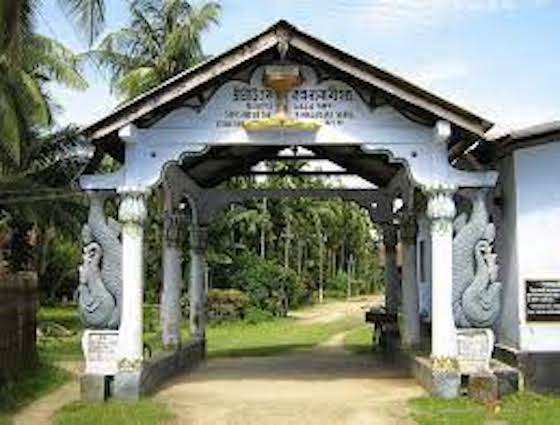

In [26]:
from PIL import Image

image = Image.open(dataset[0]['image_id'])
image

In [27]:
import itertools

labels = [item['ids'] for item in dataset['labels']]
flattened_labels = list(itertools.chain(*labels))
unique_labels = list(set(flattened_labels))

label2id = {label: idx for idx, label in enumerate(unique_labels)}
id2label = {idx: label for label, idx in label2id.items()}

In [28]:
def replace_ids(inputs):
    inputs["labels"]["ids"] = [label2id[x] for x in inputs["labels"]["ids"]]
#     print(inputs["labels"]["ids"])
    return inputs


dataset = dataset.map(replace_ids)
flat_dataset = dataset.flatten()
flat_dataset.features

  0%|          | 0/2678 [00:00<?, ?ex/s]

{'image_id': Value(dtype='string', id=None),
 'question': Value(dtype='string', id=None),
 'labels.ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'labels.weights': Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None)}

In [29]:
# import itertools

# val_labels = [item['ids'] for item in val_data['labels']]
# val_flattened_labels = list(itertools.chain(*val_labels))
# val_unique_labels = list(set(val_flattened_labels))

# label2id = {label: idx for idx, label in enumerate(val_unique_labels)}
# id2label = {idx: label for label, idx in label2id.items()}

# val_data = val_data.map(replace_ids)
# val_data = val_data.flatten()
# val_data.features

In [30]:
from transformers import ViltProcessor

processor = ViltProcessor.from_pretrained(model_checkpoint,token=secret_value_0)

preprocessor_config.json:   0%|          | 0.00/251 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [31]:
import torch
import numpy as np
from PIL import Image

def preprocess_data(examples):
    image_paths = examples['image_id']
    images = [Image.open(image_path).convert("RGB").resize((480, 480)) for image_path in image_paths]
    images = [image.convert("RGB") for image in images]
    texts = examples['question']    

    encoding = processor(images, texts, padding="max_length", truncation=True, return_tensors="pt")

    for k, v in encoding.items():
          encoding[k] = v.squeeze().tolist() if isinstance(v, torch.Tensor) else v
    targets = []

    for labels, scores in zip(examples['labels.ids'], examples['labels.weights']):
        target = np.zeros(len(id2label))

        for label, score in zip(labels, scores):
            target[label] = score
        targets.append(target.tolist())

    encoding["labels"] = targets   
    return encoding

In [32]:
processed_dataset = flat_dataset.map(preprocess_data, batched=True,batch_size=50, remove_columns=['question', 'image_id', 'labels.ids', 'labels.weights'])

  0%|          | 0/54 [00:00<?, ?ba/s]

In [33]:
processed_dataset

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'pixel_values', 'pixel_mask', 'labels'],
    num_rows: 2678
})

In [34]:
#processed_dataset = flat_dataset.map(preprocess_data, batched=True, remove_columns=['answer_type'])
#processed_dataset

In [35]:
#processed_dataset = flattened_df.map(preprocess_data, batched=True, batch_size=4,remove_columns=['image_id','question','labels'])
#processed_dataset

In [36]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

In [37]:
# from transformers import ViltForQuestionAnswering

# model = ViltForQuestionAnswering.from_pretrained(model_checkpoint)

In [38]:
from transformers import ViltForQuestionAnswering

# model = ViltForQuestionAnswering.from_pretrained(model_checkpoint)
model = ViltForQuestionAnswering.from_pretrained(model_checkpoint, num_labels=len(id2label))
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of ViltForQuestionAnswering were not initialized from the model checkpoint at dandelin/vilt-b32-mlm and are newly initialized: ['classifier.0.bias', 'classifier.0.weight', 'classifier.1.bias', 'classifier.1.weight', 'classifier.3.bias', 'classifier.3.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViltForQuestionAnswering(
  (vilt): ViltModel(
    (embeddings): ViltEmbeddings(
      (text_embeddings): TextEmbeddings(
        (word_embeddings): Embedding(30522, 768)
        (position_embeddings): Embedding(40, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (patch_embeddings): ViltPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
      )
      (token_type_embeddings): Embedding(2, 768)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViltEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViltLayer(
          (attention): ViltAttention(
            (attention): ViltSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=76

In [39]:
from transformers import TrainingArguments

repo_id = "MariaK/vilt_finetuned_200"

training_args = TrainingArguments(
    output_dir=repo_id,
    per_device_train_batch_size=1,
    num_train_epochs=10,
#     evaluation_strategy="epoch",  # Evaluate at the end of each epoch
    save_steps=200,
    logging_steps=50,
    learning_rate=5e-5,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=True,
    hub_token=secret_value_0,
)

In [40]:
from sklearn.metrics import accuracy_score
from transformers import EvalPrediction

def compute_metrics(p: EvalPrediction):
    # For binary and multiclass classification, you might need to apply an argmax over your model outputs to get the predicted class indices
    preds = np.argmax(p.predictions, axis=1) if len(p.predictions.shape) > 1 else p.predictions
    labels = p.label_ids
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

In [41]:
from transformers import TrainerCallback, TrainerState, TrainerControl
import pandas as pd

class MetricsLoggerCallback(TrainerCallback):
    "A custom callback that logs training and validation metrics for later analysis."
    def __init__(self):
        self.metrics_history = []

    def on_log(self, args, state: TrainerState, control: TrainerControl, logs=None, **kwargs):
        # Logs is a dictionary that the trainer populates; it already includes some metrics
        if logs is not None:
            self.metrics_history.append(logs)

    def on_train_end(self, args, state: TrainerState, control: TrainerControl, **kwargs):
        # At the end of training, convert the metrics history to a DataFrame and save it as a CSV
        df = pd.DataFrame(self.metrics_history)
        df.to_csv("training_metrics.csv", index=False)
        print("Training metrics saved to training_metrics.csv")
        print(df)

In [42]:
from transformers import Trainer
from transformers import EvalPrediction
from transformers import TrainerCallback

# metrics_logger_callback = MetricsLoggerCallback()
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=processed_dataset,
#     eval_dataset=processed_dataset_eval,
    tokenizer=processor,
#     compute_metrics=compute_metrics,
#     callbacks=[metrics_logger_callback],
    
)

In [43]:
trainer.train()

wandb: Currently logged in as: ukeyatul230. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.16.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.16.2
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240225_152628-zqya9pjs
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run fiery-violet-48
wandb: ⭐️ View project at https://wandb.ai/ukeyatul230/huggingface
wandb: 🚀 View run at https://wandb.ai/ukeyatul230/huggingface/runs/zqya9pjs


Step,Training Loss
50,72.937700
100,12.770500
150,7.717100
200,6.631500
250,6.393000
300,5.730300
350,5.957800
400,6.471800
450,5.794800
500,5.080200


TrainOutput(global_step=26780, training_loss=2.486392520611815, metrics={'train_runtime': 17393.2405, 'train_samples_per_second': 1.54, 'train_steps_per_second': 1.54, 'total_flos': 576586322956800.0, 'train_loss': 2.486392520611815, 'epoch': 10.0})

In [44]:
trainer.save_model(repo_id)

events.out.tfevents.1708874788.a9622c1c45c1.26.0:   0%|          | 0.00/101k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/453M [00:00<?, ?B/s]

In [45]:
trainer.push_to_hub()

CommitInfo(commit_url='https://huggingface.co/Atul8827/vilt_finetuned_200/commit/a0ad221dd9c0f9a43c759d921a26fd436044a42e', commit_message='End of training', commit_description='', oid='a0ad221dd9c0f9a43c759d921a26fd436044a42e', pr_url=None, pr_revision=None, pr_num=None)

In [46]:
from transformers import pipeline

pipe = pipeline("visual-question-answering", model="MariaK/vilt_finetuned_200", token=secret_value_0)

In [47]:
x=train_dataset['labels']
# Extract 'ids' values and store in a list
labels_list = [item['ids'][0] for item in x]

q=train_dataset['question']
z=train_dataset['image_id']
predicted_list=[]
for i in range(len(q)):
    # prepare inputs
    try:
        img = Image.open(z[i])
        img = img.convert("RGB")
#         print(i)
        inputs = processor(img, q[i], return_tensors="pt")

        model = ViltForQuestionAnswering.from_pretrained("MariaK/vilt_finetuned_200")

        # forward pass
        with torch.no_grad():
            outputs = model(**inputs)

        logits = outputs.logits
        idx = logits.argmax(-1).item()
        w=model.config.id2label[idx]
        predicted_list.append(w)
    except:
        print(z[i])
        continue

# Extract the predicted labels from the list of dictionaries
predicted_list = [item for item in predicted_list]

# Calculate accuracy
correct_predictions = sum(1 for true, pred in zip(labels_list, predicted_list) if true == pred)
total_predictions = len(labels_list)
accuracy = correct_predictions / total_predictions

print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 0.00%


In [48]:
example = dataset[300]
image = Image.open(example['image_id'])
question = example['question']
print(question)
x = example['labels']
y = x['ids']
print(id2label[y[0]])
pipe(image, question, top_k=1)

what is the best timing to visit this place?
8:00-16:00


[{'score': 0.4011892080307007, 'answer': 'LABEL_13'}]

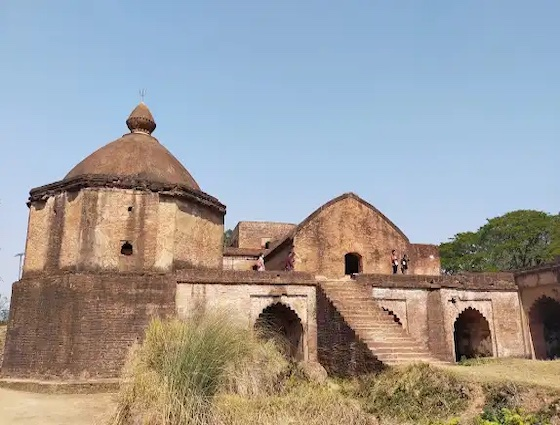

In [49]:
from PIL import Image

image1 = Image.open(example['image_id'])
image1

In [50]:
processor = ViltProcessor.from_pretrained("MariaK/vilt_finetuned_200")

image = Image.open(example['image_id'])
question = 'what is the best hotel near it'

# prepare inputs
inputs = processor(image, question, return_tensors="pt")

model = ViltForQuestionAnswering.from_pretrained("MariaK/vilt_finetuned_200")

# forward pass
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
idx = logits.argmax(-1).item()
print(question)
x = example['labels']
y = x['ids']
print(id2label[idx])
print(idx)
print("Predicted answer:", model.config.id2label[idx])

what is the best hotel near it
sona_hotel
30
Predicted answer: LABEL_30


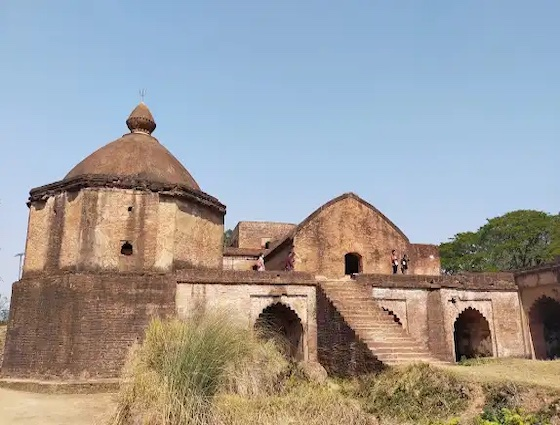

In [51]:
from PIL import Image

image1 = Image.open(example['image_id'])
image1

In [52]:
'''from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)'''

'from transformers import AutoProcessor, Blip2ForConditionalGeneration\nimport torch\n\nprocessor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")\nmodel = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16)\ndevice = "cuda" if torch.cuda.is_available() else "cpu"\nmodel.to(device)'

In [53]:
'''example = dataset[7]
image = Image.open(example['image_id'])
question = example['question']'''

"example = dataset[7]\nimage = Image.open(example['image_id'])\nquestion = example['question']"

In [54]:
#question

In [55]:
#image

In [56]:
#prompt = f"Question: {question} Answer:"

In [57]:
'''inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=10)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)'''

'inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)\n\ngenerated_ids = model.generate(**inputs, max_new_tokens=10)\ngenerated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()\nprint(generated_text)'